# MAB with 1 decision : jump or not jump (2 arms)

In [60]:
import random
import matplotlib.pyplot as plt
import subprocess
import tempfile
import json

def train_2_arms_MAB(run_game_function, weight_size, generations=1000, epsilon=0, epsilon_decay=1, name="No Name"):
    best_weights = [random.uniform(-1, 1) for _ in range(weight_size)]
    best_score = run_game_function(best_weights)

    epsilon_min = 0
    scores = []
    moving_avg = []
    epsilons = []

    for gen in range(generations):
        epsilons.append(epsilon)

        if random.random() < epsilon:
            weights = [random.uniform(-2, 2) for _ in range(weight_size)]
        else:
            weights = [w + random.uniform(-0.2, 0.2) for w in best_weights]

        score = run_game_function(weights)

        scores.append(score)
        avg = sum(scores[-100:]) / min(len(scores), 100)
        moving_avg.append(avg)

        print(f"Génération {gen} | Score: {score:.2f} | ε={epsilon:.4f}")

        if score > best_score:
            best_score = score
            best_weights = weights
            print("🎉 Nouveau meilleur score:", best_score)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print("\n--- Entraînement terminé ---")
    print("Meilleur score:", best_score)
    print("Poids optimaux trouvés:", best_weights)
    final_weights = best_weights

    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Générations")
    ax1.set_ylabel("Score", color='tab:blue')
    ax1.plot(scores, label="Scores", color='tab:blue', alpha=0.5)
    ax1.plot(moving_avg, label="Moyenne mobile 100 générations", color='tab:red', linestyle='dashed')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel("ε (Epsilon)", color='tab:green')
    ax2.plot(epsilons, label="Épsilon", color='tab:green', linestyle='dotted')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    fig.tight_layout()
    plt.title(name)
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()

    print("Lancement de la meilleure partie...")
    #run_game_function(final_weights, render=True, manual=False)

    with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.json') as f:
        json.dump(final_weights, f)
        temp_file_path = f.name

    subprocess.run(["python", "jeuSimple.py", temp_file_path])



## Flappy bird CLASSIQUE

In [61]:
from jeuSimple import run_game as run_game_classique
# In this file there is the code for the game especially the code of the function "should_jump" that decide if the bird jumps or not each frame using the weights we "chosed"

#def should_jump(bird, pipes, weights):
#    
#    ...
#
#    decision = (weights[0] * dy_top + 
#                weights[1] * dy_bottom + 
#                weights[2] * dx + 
#                weights[3] * v + 
#                weights[4] * altitude) 
#
#    return decision < 0

# I dont copy it here because I would have multiple games de copy in this notebook

In [58]:
!python epsilon.py simple


^C


pygame 2.6.1 (SDL 2.28.4, Python 3.12.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Génération 0 | Score: 56254.00 | ε=1.0000
🎉 Nouveau meilleur score: 56254
Génération 1 | Score: 55.00 | ε=0.9950
Génération 2 | Score: 35.00 | ε=0.9900
Génération 3 | Score: 55.00 | ε=0.9851
Génération 4 | Score: 35.00 | ε=0.9801
Génération 5 | Score: 376.00 | ε=0.9752
Génération 6 | Score: 35.00 | ε=0.9704
Génération 7 | Score: 57313.00 | ε=0.9655
🎉 Nouveau meilleur score: 57313
Génération 8 | Score: 55.00 | ε=0.9607
Génération 9 | Score: 81.00 | ε=0.9559
Génération 10 | Score: 55.00 | ε=0.9511
Génération 11 | Score: 35.00 | ε=0.9464
Génération 12 | Score: 55.00 | ε=0.9416
Génération 13 | Score: 55.00 | ε=0.9369
Génération 14 | Score: 35.00 | ε=0.9322
Génération 15 | Score: 55.00 | ε=0.9276
Génération 16 | Score: 223.00 | ε=0.9229
Génération 17 | Score: 35.00 | ε=0.9183
Génération 18 | Score: 41423.00 | ε=0.9137
Génération 19 | Score: 55.00 | ε=0.9092
Génération 20 | Score

### Epsilon greedy

Génération 0 | Score: 55.00 | ε=0.1000
Génération 1 | Score: 55.00 | ε=0.1000
Génération 2 | Score: 55.00 | ε=0.1000
Génération 3 | Score: 55.00 | ε=0.1000
Génération 4 | Score: 331.00 | ε=0.1000
🎉 Nouveau meilleur score: 331
Génération 5 | Score: 332.00 | ε=0.1000
🎉 Nouveau meilleur score: 332
Génération 6 | Score: 55.00 | ε=0.1000
Génération 7 | Score: 331.00 | ε=0.1000
Génération 8 | Score: 331.00 | ε=0.1000
Génération 9 | Score: 331.00 | ε=0.1000
Génération 10 | Score: 344.00 | ε=0.1000
🎉 Nouveau meilleur score: 344
Génération 11 | Score: 331.00 | ε=0.1000
Génération 12 | Score: 331.00 | ε=0.1000
Génération 13 | Score: 331.00 | ε=0.1000
Génération 14 | Score: 35.00 | ε=0.1000
Génération 15 | Score: 332.00 | ε=0.1000
Génération 16 | Score: 331.00 | ε=0.1000
Génération 17 | Score: 35.00 | ε=0.1000
Génération 18 | Score: 35.00 | ε=0.1000
Génération 19 | Score: 331.00 | ε=0.1000
Génération 20 | Score: 55.00 | ε=0.1000
Génération 21 | Score: 35.00 | ε=0.1000
Génération 22 | Score: 331.0

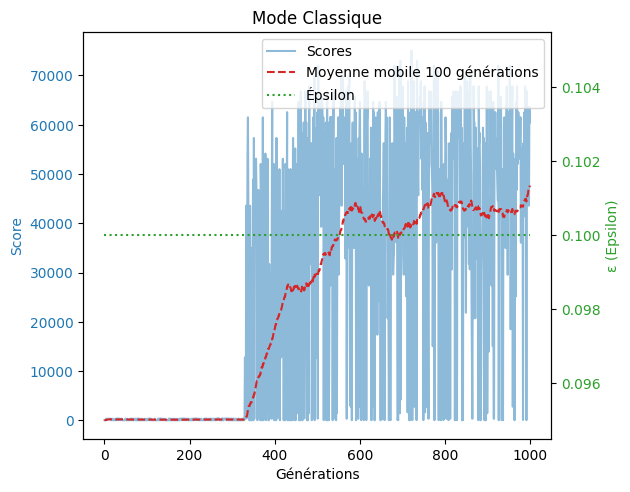

Lancement de la meilleure partie...


In [62]:
train_2_arms_MAB(run_game_function=run_game_classique, weight_size=5, generations=1000, epsilon=0.1, epsilon_decay=1, name="Mode Classique")

### Epsilon greedy decaying

In [ ]:
train_2_arms_MAB(run_game_function=run_game_classique, weight_size=5, generations=1000, epsilon=1, epsilon_decay=0.995, name="Mode Classique")

### No epsilon greedy

In [ ]:
train_2_arms_MAB(run_game_function=run_game_classique, weight_size=5, generations=1000, epsilon=0, epsilon_decay=0, name="Mode Classique")

Flappy Bird complex version

In [ ]:
from jeuComplexe import run_game_complexe

### Epsilon greedy

In [ ]:
train_2_arms_MAB(run_game_function=run_game_complexe, weight_size=5, generations=1000, epsilon=0.1, epsilon_decay=1, name="Mode Complexe")

### Epsilon greedy decaying

In [ ]:
train_2_arms_MAB(run_game_function=run_game_complexe, weight_size=5, generations=1000, epsilon=1, epsilon_decay=0.995, name="Mode Complexe")

### No epsilon greedy

In [ ]:
train_2_arms_MAB(run_game_function=run_game_complexe, weight_size=5, generations=1000, epsilon=0, epsilon_decay=0, name="Mode Complexe")

# MAB with 2 decisions : jumps and ability (4 arms)

# MAB using batches